In [1]:
from natpn import suppress_pytorch_lightning_logs
suppress_pytorch_lightning_logs()

In [2]:
import pytorch_lightning as pl
pl.seed_everything(42)

42

In [3]:
from natpn.nn import NaturalPosteriorNetworkModel
from natpn.model.lightning_module import NaturalPosteriorNetworkLightningModule
from natpn.nn.output import NormalOutput
from natpn.nn.flow import RadialFlow
from natpn.nn.encoder import TabularEncoder

# Toy Datamodule

In [4]:
from typing import Union, Callable
import numpy as np
from scipy import stats
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams["figure.figsize"] = [28, 9]


def polynomial_f2(x):
    """Polynomial function."""
    w = np.array([-0.6667, -0.6012, -1.0172, -0.7687, 2.4680, -0.1678])
    fx = 0
    for i in range(len(w)):
        fx += w[i] * (x**i)
    fx *= np.sin(np.pi * x)
    fx *= np.exp(-0.5 * (x**2)) / np.sqrt(2 * np.pi)
    return fx


class ToyHeteroscedasticDatamodule(pl.LightningDataModule):
    """Implement Toy Dataset with heteroscedastic noise."""

    def __init__(
        self,
        x_min: Union[int, float] = -4,
        x_max: Union[int, float] = 4,
        n_train: int = 200,
        n_true: int = 200,
        sigma: float = 0.3,
        batch_size: int = 200,
        generate_y: Callable = polynomial_f2,
    ) -> None:
        """Define a heteroscedastic toy regression dataset.

        Taken from (https://mapie.readthedocs.io/en/latest/examples_regression/
        1-quickstart/plot_heteroscedastic_1d_data.html#sphx-glr-examples-
        regression-1-quickstart-plot-heteroscedastic-1d-data-py)

        Args:
            n_train : Number of training samples, by default  200.
            n_true: Number of test samples, by default 1000.
            sigma: Standard deviation of noise, by default 0.1
            batch_size: batch size for data loader
            generate_y: function that should generate data over input line
        """
        super().__init__()
        np.random.seed(1)
        q95 = stats.norm.ppf(0.95)
        X_train = np.linspace(x_min, x_max, n_train)
        X_test = np.linspace(x_min + 0.1 * x_min, x_max + x_max * 0.3, n_true)
        y_train = generate_y(X_train) + np.random.normal(
            0, sigma, n_train
        ) * np.linspace(0.1, 1, n_train)
        y_true = generate_y(X_test)

        # "True" noise
        y_true_sigma = q95 * sigma * X_test  # noqa: F841

        # train loader
        gap_start = x_min + 0.5 * (x_max - x_min)
        gap_end = x_min + 0.6 * (x_max - x_min)

        test_idx = ((X_train > gap_start) & (X_train < gap_end)).squeeze()

        X_train = torch.from_numpy(X_train).unsqueeze(-1).type(torch.float32)
        self.X_train = X_train[~test_idx]
        y_train = torch.from_numpy(y_train).type(torch.float32)
        self.y_train = y_train[~test_idx]

        self.X_test = torch.from_numpy(X_test).unsqueeze(-1).type(torch.float32)
        self.y_test = torch.from_numpy(y_true).type(torch.float32)

        self.batch_size = batch_size

    def train_dataloader(self) -> DataLoader:
        """Return train dataloader."""
        return DataLoader(
            TensorDataset(self.X_train, self.y_train), batch_size=self.batch_size
        )

    def val_dataloader(self) -> DataLoader:
        """Return val dataloader."""
        # TODO Validation data
        return DataLoader(
            TensorDataset(self.X_train, self.y_train), batch_size=self.batch_size
        )

    def test_dataloader(self) -> DataLoader:
        """Return test dataloader."""
        return DataLoader(
            TensorDataset(self.X_test, self.y_test), batch_size=self.batch_size
        )
    
    def transform_output(self, input: torch.Tensor):
        """Transform output required by NatPN."""
        return input

In [5]:
dm = ToyHeteroscedasticDatamodule()

# Plot Toy Data

Text(0.5, 1.0, 'Heteroscedastic Toy Data Example with Gap.')

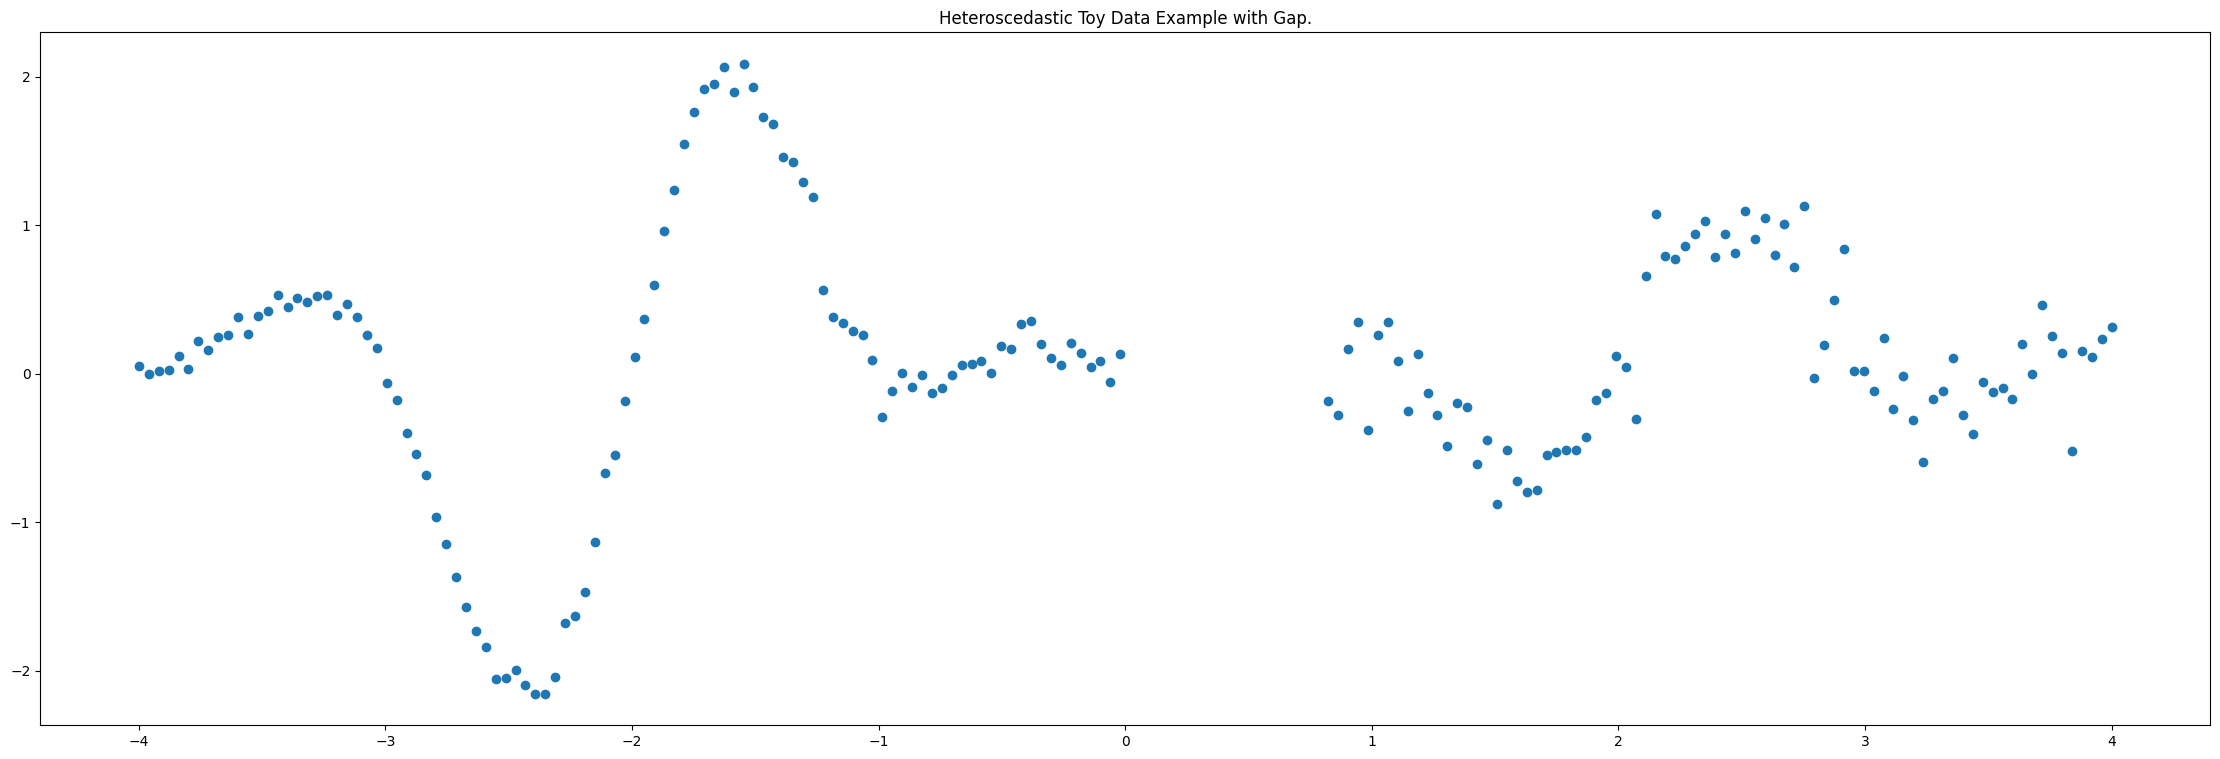

In [29]:
fig, ax = plt.subplots(1)
ax.scatter(dm.X_train.numpy(), dm.y_train.numpy())
ax.set_title("Heteroscedastic Toy Data Example with Gap.")

# NATPN Model and Lightning Module

In [35]:
latent_dim = 16

encoder = TabularEncoder(
                1, [24, 24], latent_dim, dropout=0
            )
flow = RadialFlow(latent_dim, num_layers=4)
output = NormalOutput(latent_dim)


natp_pn_network = NaturalPosteriorNetworkModel(
    latent_dim=latent_dim,
    encoder=encoder,
    flow=flow,
    output=output,
    certainty_budget="normal"
)

module = NaturalPosteriorNetworkLightningModule(
    model=natp_pn_network,
    learning_rate=2e-3,
    learning_rate_decay=False,
    entropy_weight=0.00001
)

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


# Train with Lightning Trainer

In [37]:
trainer = pl.Trainer(max_epochs=500, enable_progress_bar=False)

trainer.fit(module, dm)

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


# Make Prediction and compute Uncertainty Decomposition

In [38]:
with torch.no_grad():
    posterior, log_prob = module.model(dm.X_test)

In [39]:
mean = posterior.maximum_a_posteriori().mean().cpu().numpy()
epistemic = torch.clone(log_prob).cpu().numpy()
aleatoric = posterior.maximum_a_posteriori().uncertainty().cpu().numpy()

Text(0.5, 1.0, 'Aleatoric UCT')

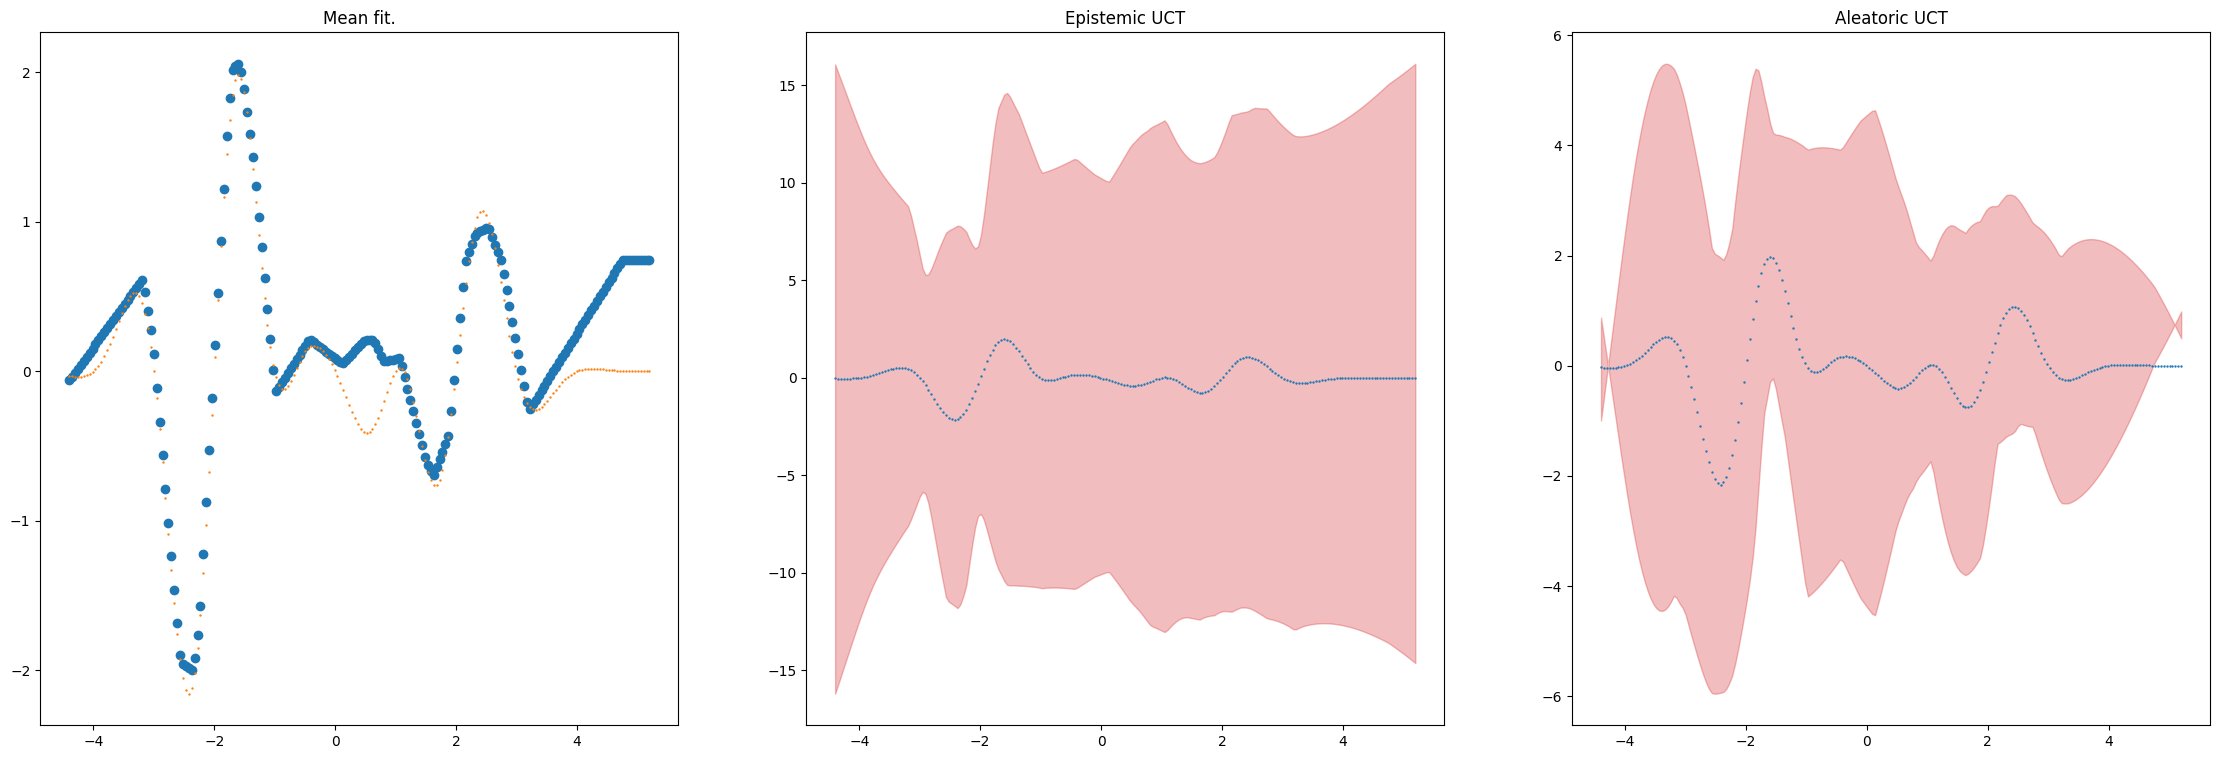

In [40]:
x_test = dm.X_test.numpy()
fig, ax = plt.subplots(ncols=3)
ax[0].scatter(x_test, mean, label="pred")
ax[0].scatter(x_test, dm.y_test.numpy(), label="y_true", s=0.5)
ax[0].set_title("Mean fit.")

# epistemic uct
ax[1].fill_between(
    x_test.squeeze(),
    mean - epistemic,
    mean + epistemic,
    alpha=0.3,
    color="tab:red",
    label=r"epistemic",
)
ax[1].scatter(x_test, dm.y_test.numpy(), label="y_true", s=0.5)
ax[1].set_title("Epistemic UCT")

# aleatoric uct
ax[2].fill_between(
    x_test.squeeze(),
    mean - aleatoric,
    mean + aleatoric,
    alpha=0.3,
    color="tab:red",
    label=r"epistemic",
)
ax[2].scatter(x_test, dm.y_test.numpy(), label="y_true", s=0.5)
ax[2].set_title("Aleatoric UCT")